max frequency in heatmap for run 30: 0.3093813246086006
max frequency in heatmap for run 0: 0.21587747048681416
max frequency in heatmap for run 10: 0.2717080599371128


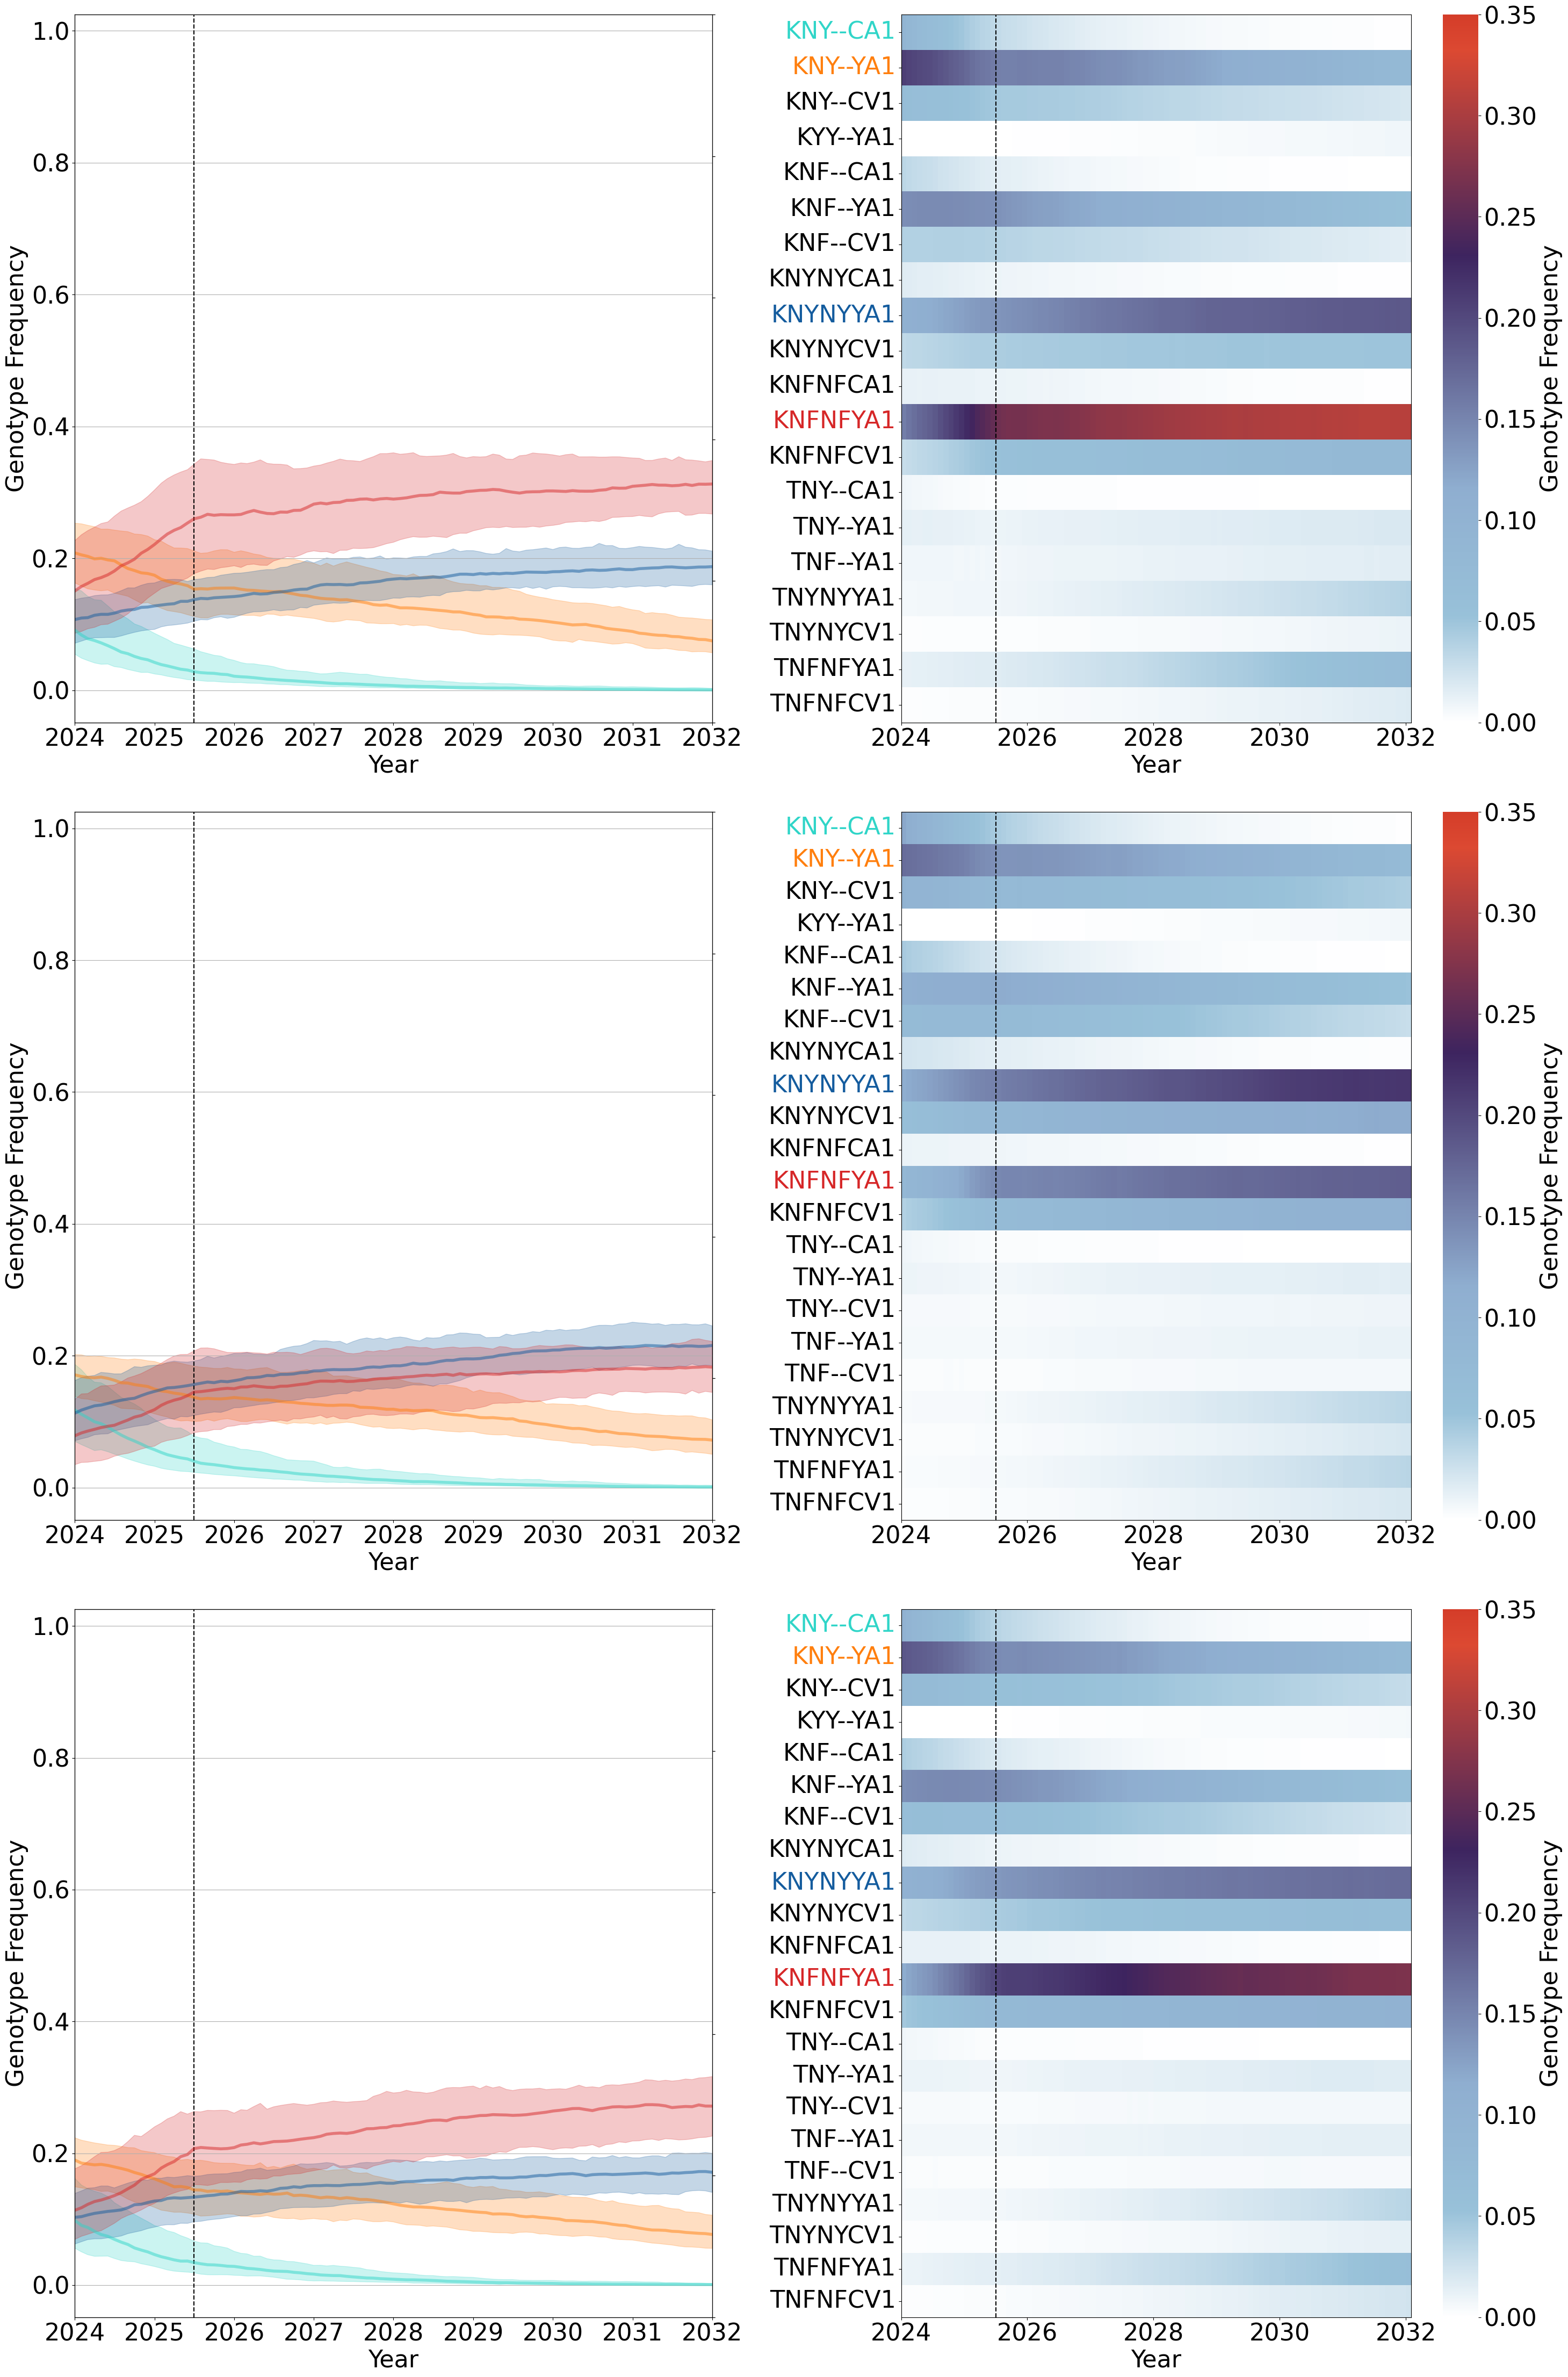

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import sqlite3
from datetime import datetime
import numpy as np

def plot_freq_median_iqr(monthly_data, ax, frequency_limit, ylabel, xlimit=None, palette=None, lower_iqr=0.25, upper_iqr=0.75):
    """
    Plots the median and shades the IQR (25th to 75th percentile) for each genotype.

    Args:
    - monthly_data (DataFrame): The input dataframe containing genotype frequency data.
    - ax (matplotlib.axes._subplots.AxesSubplot): The axis on which to plot.
    - palette (str or list): A valid seaborn color palette name or list of colors.
    - frequency_limit (float): The frequency threshold to filter genotypes for plotting.
    """
    # Calculating median and IQR for each genotype
    median_df = monthly_data.groupby("date").median()
    iqr25_df = monthly_data.groupby("date").quantile(lower_iqr)
    iqr75_df = monthly_data.groupby("date").quantile(upper_iqr)

    # Dropping unnecessary columns
    median_df.drop(columns=["monthlydataid", "locationid"], inplace=True)
    iqr25_df.drop(columns=["monthlydataid", "locationid"], inplace=True)
    iqr75_df.drop(columns=["monthlydataid", "locationid"], inplace=True)

    # Keeping only columns that meet the threshold for median and IQR data
    median_df = median_df.loc[:, (median_df.max() > frequency_limit)]
    iqr25_df = iqr25_df.loc[:, (iqr25_df.max() > frequency_limit)]
    iqr75_df = iqr75_df.loc[:, (iqr75_df.max() > frequency_limit)]

    if palette is not None:
        sns.set_palette(palette)

    # Plotting the median lines for each genotype
    for column in median_df.columns:
        if median_df[column].max() > 0.15:
            plot = sns.lineplot(x=median_df.index, y=median_df[column], ax=ax, label=column, lw=4, color="k" if palette is None else None,alpha = 0.5)
        else:
            plot = sns.lineplot(x=median_df.index, y=median_df[column], ax=ax, label=column, lw=4, color="gray", alpha=0.0)
        # Shading between IQR 25 and 75 if median values are above the threshold        
        if column in iqr25_df.columns and column in iqr75_df.columns:
            if median_df[column].max() > 0.15:
                ax.fill_between(median_df.index, iqr25_df[column], iqr75_df[column], alpha=0.25)

    # Customize plot (optional, could be part of the function or done outside)
    ax.legend().remove()
    ax.set_ylabel(ylabel)
    if xlimit:
        ax.set_xlim(xlimit)
    else:
        ax.set_xlim(median_df.index.min(), median_df.index.max())
    ax.set_xlabel("Year")
    ax.grid(axis='y')
    
    return median_df,plot

def plot_freq_median_iqr_v2(monthly_data, ax, ylabel, selected_genotypes, xlimit=None, lower_iqr=0.25, upper_iqr=0.75):
    """
    Plots the median and shades the IQR (25th to 75th percentile) for each selected genotype.
    """
    # Calculating median and IQR for each genotype
    median_df = monthly_data.groupby("date").median()
    iqr25_df = monthly_data.groupby("date").quantile(lower_iqr)
    iqr75_df = monthly_data.groupby("date").quantile(upper_iqr)

    # Dropping unnecessary columns
    median_df.drop(columns=["monthlydataid", "locationid"], inplace=True)
    iqr25_df.drop(columns=["monthlydataid", "locationid"], inplace=True)
    iqr75_df.drop(columns=["monthlydataid", "locationid"], inplace=True)

    # filtering median_df, iqr25_df, iqr75_df to only include selected_genotypes
    median_df = median_df.loc[:, median_df.columns.isin(selected_genotypes.keys())]
    iqr25_df = iqr25_df.loc[:, iqr25_df.columns.isin(selected_genotypes.keys())]
    iqr75_df = iqr75_df.loc[:, iqr75_df.columns.isin(selected_genotypes.keys())]


    # Plotting the median lines for each genotype
    for column in median_df.columns:
        # print(f"Plotting genotype: {column}")
        # get color from selected_genotypes
        color = selected_genotypes.get(column, "gray")
        # plot = sns.lineplot(x=median_df.index, y=median_df[column], ax=ax, label=column, lw=4, color=color, alpha=0.0)
        ax.fill_between(median_df.index, iqr25_df[column], iqr75_df[column], alpha=0.25, color=color)
        plot = sns.lineplot(x=median_df.index, y=median_df[column], ax=ax, label=column, lw=4, color=color,alpha = 0.5, zorder=3)

    # Customize plot (optional, could be part of the function or done outside)
    ax.legend().remove()
    ax.set_ylabel(ylabel)
    if xlimit:
        ax.set_xlim(xlimit)
    else:
        ax.set_xlim(median_df.index.min(), median_df.index.max())
    ax.set_xlabel("Year")
    ax.grid(axis='y')
    
    return median_df,plot

frequency_limit = 0.005
runs = [30, 0, 10]
sns.reset_defaults()
rc = {
    # "font.family" : "Consolas", 
      "font.style" : "normal",
      "font.size" : 32,
      "mathtext.fontset" : "dejavusans"}
plt.rcParams.update(rc)

fig,axes = plt.subplots( len(runs),2,figsize=(30,15* len(runs)),sharex=False)
for i, run in enumerate(runs):
    ax0 = axes[i,0]
    ax1 = axes[i,1]
    
    monthly_gen_frequency = pd.read_csv(f"./data/fig2_data_{run}.csv")
    monthly_gen_frequency['date'] = pd.to_datetime(monthly_gen_frequency['date'])
    plot_df = monthly_gen_frequency.groupby("date").mean().drop(columns=["monthlydataid", "locationid"])

    plot_df = plot_df.T

    colors = [
        (0.0, 'white'),      # 0.0 is white
        (0.15, '#98c1d9'),    # light blue
        (0.33, '#8faed0'),    # more visible blue
        # (0.40, '#6f4b9b'),    # stronger dark violet-blue
        # (0.46, '#4e3378'),    # darker violet
        (0.66, '#3d245f'),    # deep violet
        # (0.75, '#ee6c4d'),    # light orange
        # (0.85, '#e86044'),
        # (0.9, '#e2553b'),
        (0.95, '#dc4932'),
        (1.0, '#d43d29')     # deeper orange
    ]

    cmap= LinearSegmentedColormap.from_list("custom_cmap", colors, N=512)

    date_to_plot = (datetime(2024,1,1), datetime(2032,1,1))

    selected_genotypes = {
        'KNY--CA1': '#30d5c8',
        'KNY--YA1': '#ff7f0e',
        'KNYNYYA1': '#145c9e',
        'KNFNFYA1': '#d62728',
    }

    freq_median_df,freq_median_plot = plot_freq_median_iqr_v2(monthly_gen_frequency, ax0, 
                                                         "Genotype Frequency", 
                                                        selected_genotypes, xlimit=date_to_plot,
                                                        lower_iqr=0.05, upper_iqr=0.95)

    #set plot_df column in date_to_plot
    plot_df = plot_df.loc[:,date_to_plot[0]:date_to_plot[1]]

 # Determine which rows have all values <= 0.01
    mask = plot_df.max(axis=1) > frequency_limit  # Change 'max' to another function if a different logic is needed
    plot_df = plot_df[mask]

    plot = sns.heatmap(plot_df, yticklabels=True,xticklabels=True,
                        cmap=cmap, vmin=0, vmax=0.35, 
                        cbar_kws={'label': 'Genotype Frequency'},
                        ax=ax1)
    print(f"max frequency in heatmap for run {run}: {plot_df.values.max()}")

    # plot.collections[0].colorbar.ax.set_ylim(0, 0.5)
    #display border for heatmap
    plot.spines['top'].set_visible(True)
    plot.spines['bottom'].set_visible(True)
    plot.spines['left'].set_visible(True)
    plot.spines['right'].set_visible(True)
    plot_df_columns = [date.strftime('%Y') for date in plot_df.columns]

    #set the color of yticklabels using the same color as the lineplot in axes[0]
    #check if the label name matched label in lineplot
    for label in plot.get_yticklabels():
        if label.get_text() in freq_median_df.columns:
            label.set_color(freq_median_plot.get_lines()[list(freq_median_df.columns).index(label.get_text())].get_color())
        else:
            label.set_color("black")

    xticklabels = [date.strftime('%Y') if (date.month == 1) & (date.year % 2 ==0) else '' for date in plot_df.columns]
    ticks = [i for i, label in enumerate(xticklabels) if label] 
    ax1.set_xticks(ticks=ticks, labels=[xticklabels[i] for i in ticks], rotation=0)  # Adjust rotation if needed
    ax1.set_xlabel('Year')
    pos = np.where(plot_df.columns == datetime(2025, 7, 1))[0][0]
    ax0.axvline(x=datetime(2025,7,1), color='k', linestyle='--')
    ax1.axvline(x=pos, color='k', linestyle='--')

    axes_pfpr = ax0.twinx()
    axes_tf = ax0.twinx()

    axes_pfpr.set_yticklabels([])
    axes_tf.set_yticklabels([])
    axes_pfpr.set_ylabel("")
    axes_tf.set_ylabel("")

plt.tight_layout()
plt.show()
fig.savefig(f"figure_2.png", dpi=300)